## Generalized lomb scargle periodogram

The [Lomb](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L)-[Scargle](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) periodogram performs a least-squares fit of sinusoids to your data

$$
P_{LS} = \frac{1}{2}(\chi^2_0 - \chi^2(\omega))
$$

where

$$
\chi^2(\omega) = \min_{\theta}\left[\sum_i w_i (y_i - \hat{y}(t_i, \omega|\theta))^2\right],
$$

is the sum of squared residuals for the best fit model,

$$
\chi^2_0 = \sum_i w_i (y_i - \bar{y})^2,
$$

is the sum of squared residuals for a constant model, with

$$
w_i = W \sigma_i^{-2},
$$

$$
W = \left[\sum \sigma_i^{-2}\right]^{-1},
$$

being the weights for the weighted sum, and

$$
\bar{y} = \sum w_i y_i
$$

being the weighted mean of the data. The model being fit to the data takes the form

$$
\hat{y}(t_i, \omega |\theta) = \theta_1\cos{\omega t_i} + \theta_2\sin{\omega t_i} + \theta_3.
$$

The original Lomb-Scargle implementation omits the constant offset -- $\theta_3$ -- parameter, which was introduced in [Zechmeister and Kurster (2009)](http://adsabs.harvard.edu/abs/2009A%26A...496..577Z) 

If you want to learn more about the Lomb-Scargle periodogram, its implications, limitations, and extensions, see [Vanderplas (2017)](https://arxiv.org/abs/1703.09824). 

The [astropy](http://docs.astropy.org/en/stable/index.html) package has an implementation with instructive [documentation](http://docs.astropy.org/en/stable/stats/lombscargle.html)

The cuvarbase lomb scargle implementation is normalized to


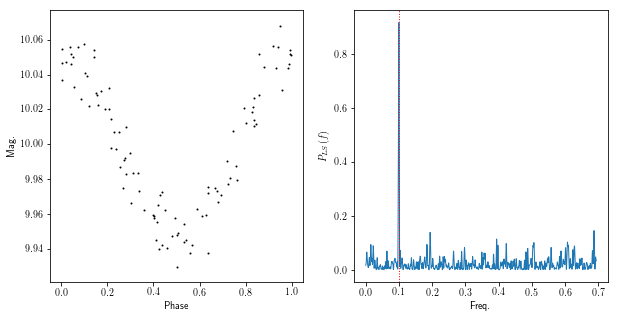

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats.lombscargle import LombScargle

def data(ndata=100, freq=0.1, y0=10., amp=0.05, sigma=0.01, baseline=365., seed=100):
    rand = np.random.RandomState(seed)
    t = baseline * np.sort(rand.rand(ndata))
    y = y0 + amp * np.cos(2 * np.pi * freq * t)
    dy = sigma * np.ones_like(y)
    
    y += dy * rand.randn(len(t))
    
    return t, y, dy


f0 = 0.1

# generate fake lightcurve
t, y, dy = data(freq=f0)

# Run lomb scargle
freqs, powers = LombScargle(t, y, dy).autopower()

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(10, 5))

axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, powers)
axlsp.axvline(f0, ls=':', color='r')
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$P_{LS}(f)$')
plt.show()

## Using `LombScargleAsyncProcess`

``cuvarbase`` uses its own implementation of the [non-equispaced fast Fourier transform](http://epubs.siam.org/doi/abs/10.1137/0914081) to compute frequency-dependent sums in the calculation of the periodogram. Using the NFFT to speed up the calculation of the LS periodogram was first demonstrated in [Leroy (2012)](https://www.aanda.org/articles/aa/abs/2012/09/aa19076-12/aa19076-12.html).


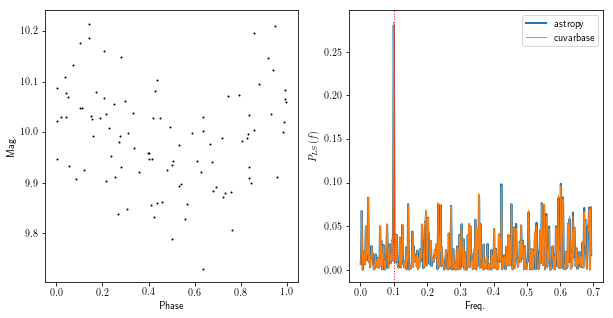

False alarm probability:  0.000109046992672


In [19]:
from cuvarbase.lombscargle import LombScargleAsyncProcess

f0 = 0.1
t, y, dy = data(freq=f0, sigma=0.08)

# Initialize process
proc = LombScargleAsyncProcess()

# Run lomb scargle
results = proc.run([(t, y, dy)])

# Parse the results
freqs, powers = results[0]

# Run the astropy Lomb Scargle
powers_astropy = LombScargle(t, y, dy).power(freqs)

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(10, 5))
axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, powers_astropy, alpha=1, lw=2, label='astropy')
axlsp.plot(freqs, powers, alpha=1, label='cuvarbase')
axlsp.axvline(f0, ls=':', color='r')
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$P_{LS}(f)$')
axlsp.legend(loc='best')
plt.show()

print "False alarm probability: ", fap_baluev(t, dy, max(powers), max(freqs))

# Notes

## Precision
* `use_double`: 
* `m`
* `sigma`

## Choosing frequencies


## Running LS on many lightcurves